In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('full transactions.csv', parse_dates=['SALE_DATE'])
df.head()

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SALE_DATE,MODEL_YEAR,MAKE_NAME,MODEL_NAME,VEHICLE_NAME,SEGMENT,DATA_SOURCE,SALE_PRICE_AMOUNT,MSRP_AMOUNT,MILEAGE,...,DRIVETRAIN_DESCRIPTION,BEDLENGTH,BODY_STYLE,CAB_CONFIGURATION,DOOR_COUNT,TRUCK_FLG,TRANSACTION_GEOGRAPHY_ID,CITY_DISPLAY_NAME,STATE,SALE_TYPE
0,2016-12-31,2016,Mazda,CX-5,Sport SUV 4D,Compact SUV Crossover,LUTHER,25095.00,25795,-1,...,AWD,NaN,SUV,NaN,4,NaN,19077,Minneapolis,MN,Retail
1,2016-12-31,2016,Chevrolet,Silverado 2500 HD Double Cab,LT Pickup 4D 6 1/2 ft,Truck,VIN_SOLUTIONS,42693.00,48830,5,...,4WD,6.50,Pickup,Extended,4,NaN,40840,Saint Croix Falls,WI,Retail
2,2016-12-31,2016,Ford,Edge,Sport SUV 4D,Midsize SUV Crossover,VIN_SOLUTIONS,46312.89,47755,75,...,AWD,NaN,SUV,NaN,4,NaN,10925,El Paso,IL,Retail
3,2016-12-31,2017,Ram,2500 Crew Cab,Tradesman Pickup 4D 6 1/3 ft,Truck,VIN_SOLUTIONS,43290.12,45424,13,...,4WD,6.33,Pickup,Crew,4,NaN,22329,Reno,NV,Retail
4,2016-12-31,2016,Ram,1500 Crew Cab,SLT Pickup 4D 5 1/2 ft,Truck,VIN_SOLUTIONS,39676.87,44665,15,...,2WD,5.50,Pickup,Crew,4,NaN,36423,Arlington,TX,Retail


In [7]:
df = (df.rename(columns=str.lower)
 .drop(['engine_subtype', 'bedlength', 'cab_configuration', 'truck_flg'], axis=1)
 .dropna(subset=['city_display_name']))

In [9]:
df.days_in_inventory = df.days_in_inventory.fillna(value=df.days_in_inventory.mean()).astype(int)
df.transmission_type = df.transmission_type.fillna(value='Automatic')

In [10]:
cond = (df.transmission_num_of_speeds.isnull()) & (df.transmission_description.str.contains('\d')) 
df.loc[cond, 'transmission_num_of_speeds'] = df.loc[cond, 'transmission_description'].str.extract('(\d)')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [15]:
df.transmission_num_of_speeds = df.transmission_num_of_speeds.fillna(1)
df = df.loc[df.engine_type != 'Unknown']

df.transmission_num_of_speeds = df.transmission_num_of_speeds.astype(int)

In [16]:
df.loc[df.engine_cylinders.isnull(), ['engine_cylinders']] = 0
df.loc[df.engine_displacement.isnull(), 'engine_displacement'] = 0

In [22]:
df.engine_cylinders = df.engine_cylinders.astype(int)
df.engine_displacement = df.engine_displacement.astype(float)

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['transmission_type_le'] = le.fit_transform(df.transmission_type.values)

In [25]:
eng_type = pd.get_dummies(df.engine_type)
df = pd.concat([df, eng_type], axis=1)
df.head()

,sale_date,model_year,make_name,model_name,vehicle_name,segment,data_source,sale_price_amount,msrp_amount,mileage,...,city_display_name,state,sale_type,transmission_type_le,Diesel,Electric,Flexible Fuel,Gas,Hybrid,Natural Gas
0,2016-12-31,2016,Mazda,CX-5,Sport SUV 4D,Compact SUV Crossover,LUTHER,25095.00,25795,-1,...,Minneapolis,MN,Retail,0,0,0,0,1,0,0
1,2016-12-31,2016,Chevrolet,Silverado 2500 HD Double Cab,LT Pickup 4D 6 1/2 ft,Truck,VIN_SOLUTIONS,42693.00,48830,5,...,Saint Croix Falls,WI,Retail,0,0,0,1,0,0,0
2,2016-12-31,2016,Ford,Edge,Sport SUV 4D,Midsize SUV Crossover,VIN_SOLUTIONS,46312.89,47755,75,...,El Paso,IL,Retail,0,0,0,0,1,0,0
3,2016-12-31,2017,Ram,2500 Crew Cab,Tradesman Pickup 4D 6 1/3 ft,Truck,VIN_SOLUTIONS,43290.12,45424,13,...,Reno,NV,Retail,0,0,0,0,1,0,0
4,2016-12-31,2016,Ram,1500 Crew Cab,SLT Pickup 4D 5 1/2 ft,Truck,VIN_SOLUTIONS,39676.87,44665,15,...,Arlington,TX,Retail,0,0,0,0,1,0,0


In [26]:
df['discount'] = (df.sale_price_amount / df.msrp_amount - 1) * 100

In [35]:
df = df.loc[df.segment != 'Exotic']
df.segment.value_counts()

Compact SUV Crossover     67024
Midsize SUV Crossover     47569
Midsize Car               36745
Truck                     35715
Compact Car               34033
Fullsize SUV Crossover    12624
Near Luxury Car            8992
Midsize Truck              7278
Subcompact Car             6940
Minivan                    6696
Fullsize Car               5529
Midsize Luxury Car         3688
Van                        2848
Pony Car                   2807
Compact Sports Car         2014
Compact Luxury Car         1377
High End Luxury Car        1282
High Performance            972
Import Sports Car           928
Luxury Roadster             222
Sports Car                  164
Name: segment, dtype: int64

In [28]:
cols = ['Diesel','Electric','Flexible Fuel', 'Gas', 'Hybrid','transmission_type_le', 'door_count', 'engine_displacement', 'engine_cylinders', 'days_in_inventory', 'transmission_num_of_speeds','mileage', 'msrp_amount', 'model_year', 'sale_price_amount', 'discount']

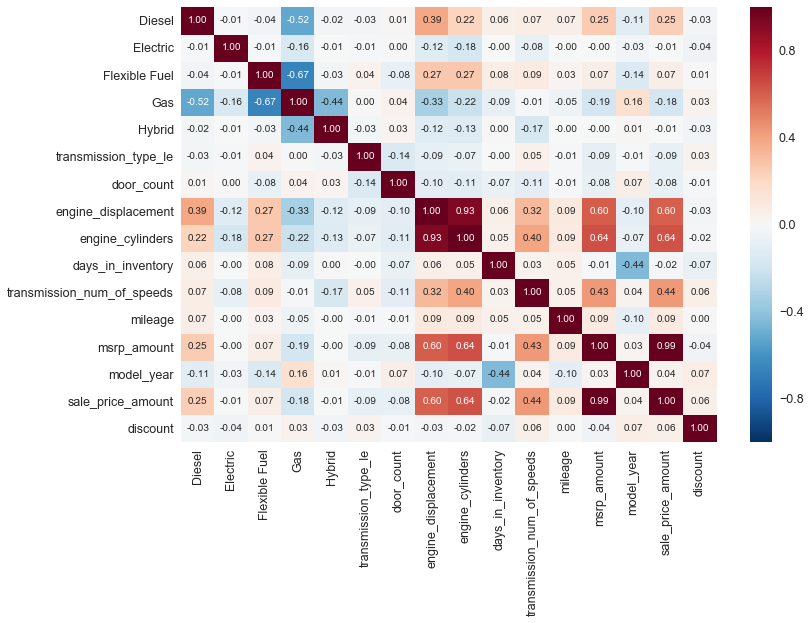

In [36]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.rcParams['figure.figsize']=(12,8)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                fmt='.2f',
                annot_kws={'size': 10},
                yticklabels=cols,
                xticklabels=cols)